'''KNN 모델을 이용한 트레이딩 알고리즘'''
'''ta-lib, pandas-datareader 설치 후 진행'''
'''ipynb파일과 Data, Data_mkt 폴더를 같은 위치에 두고 실행'''

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import talib
import pandas_datareader as pdr
import sklearn.preprocessing as preprocessing
import matplotlib.ticker as mticker
import os
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set()
from datetime import datetime
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from itertools import compress
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [2]:
'''KOSPI 전체 종목 크롤링 (기존에 데이터가 있다면 크롤링 하지 않아도 무방함) _ 시간 오래걸림 '''

# stock_type = {
# 'kospi': 'stockMkt',
# 'kosdaq': 'kosdaqMkt'
# }
# quit()
# # 회사명으로 주식 종목 코드를 획득할 수 있도록 하는 함수
# def get_code(df, name):
#     code = df.query("name=='{}'".format(name))['code'].to_string(index=False)
#     # 위와같이 code명을 가져오면 앞에 공백이 붙어있는 상황이 발생하여 앞뒤로 sript() 하여 공백 제거
#     code = code.strip()
#     return code

# # download url 조합
# def get_download_stock(market_type=None):
#     market_type = stock_type[market_type]
#     download_link = 'http://kind.krx.co.kr/corpgeneral/corpList.do'
#     download_link = download_link + '?method=download'
#     download_link = download_link + '&marketType=' + market_type
#     df = pd.read_html(download_link, header=0)[0]
#     return df

# # kospi 종목코드 목록 다운로드
# def get_download_kospi():
#     df = get_download_stock('kospi')
#     df.종목코드 = df.종목코드.map('{:06d}.KS'.format)
#     return df

# # kosdaq 종목코드 목록 다운로드
# def get_download_kosdaq():
#     df = get_download_stock('kosdaq')
#     df.종목코드 = df.종목코드.map('{:06d}.KQ'.format)
#     return df

# # kospi, kosdaq 종목코드 각각 다운로드
# kospi_df = get_download_kospi()
# #kosdaq_df = get_download_kosdaq()

# # data frame정리
# kospi_df = kospi_df[['회사명', '종목코드']]
# #kosdaq_df = kosdaq_df[['회사명', '종목코드']]

# # data frame title 변경 '회사명' = name, 종목코드 = 'code'
# kospi_df = kospi_df.rename(columns={'회사명': 'name', '종목코드': 'code'})
# #kosdaq_df = kosdaq_df.rename(columns={'회사명': 'name', '종목코드': 'code'})


# #시계열 데이터 구간 정해주기
# start_date = datetime(2001,1,1)
# end_date = datetime.now()

# #디렉토리 생성
# directory = "Data"
# path = os.getcwd()
# try:
#     os.mkdir(path + "/" + directory)
# except:
#     pass

# for i in range(len(kospi_df)):
#     try:
#         df = pdr.get_data_yahoo(kospi_df.iloc[i,1], start_date, end_date)
#         df.to_csv(f'{directory}/{kospi_df.iloc[i,0]}.csv')
#     except:
#         print(f"Loading Error: {kospi_df.iloc[i,0]}")
#         pass


'KOSPI 전체 종목 크롤링 (기존에 데이터가 있다면 크롤링 하지 않아도 무방함) _ 시간 오래걸림 '

In [3]:
'''외부 시장 데이터 저장 (코스피, 나스닥, s&p500, 다우존스, 환율)'''
'''Data_mkt폴더에 파일이 있다면 쓰지 않아도 무방함'''

# '''시계열 데이터 기간과 경로 할당'''
# start_date = datetime(2001,1,1)
# end_date = datetime.now()
#
# '''디렉토리 생성'''
# directory = 'Data_mkt'
# path_dir = os.getcwd()
# try:
#     os.mkdir(path_dir + "/" + directory)
# except:
#     pass
#
# pdr.get_data_yahoo('^KS11', start_date, end_date).to_csv(f'{path_dir}/{directory}/kospi.csv') #코스피 지수
# pdr.get_data_yahoo('^IXIC', start_date, end_date).to_csv(f'{path_dir}/{directory}/nasdaq.csv') #나스닥 지수
# pdr.get_data_yahoo('^GSPC', start_date, end_date).to_csv(f'{path_dir}/{directory}/s&p500.csv') #S&P500 지수
# pdr.get_data_yahoo('^DJI', start_date, end_date).to_csv(f'{path_dir}/{directory}/dowjones.csv') #DowJones 지수
# pdr.get_data_yahoo('KRW=X', start_date, end_date).to_csv(f'{path_dir}/{directory}/exch.csv') #원달러 환율 지수

'Data_mkt폴더에 파일이 있다면 쓰지 않아도 무방함'

In [4]:
'''필요한 데이터 불러오기'''

import os
path_dir = os.getcwd()

'''분석하려는 주식 종목'''
asset_name = 'naver' #종목명 적기

tmp1 = pd.read_csv(f"{path_dir}/Data/{asset_name}.csv", index_col='Date', parse_dates=['Date']) #자산지수
tmp2 = pd.read_csv(f"{path_dir}/Data_mkt/kospi.csv", index_col='Date', parse_dates=['Date']) #코스피지수
tmp3 = pd.read_csv(f'{path_dir}/Data_mkt/nasdaq.csv', index_col='Date', parse_dates=['Date']) #나스닥 지수
tmp4 = pd.read_csv(f'{path_dir}/Data_mkt/s&p500.csv', index_col='Date', parse_dates=['Date']) #S&P500 지수
tmp5 = pd.read_csv(f'{path_dir}/Data_mkt/dowjones.csv', index_col='Date', parse_dates=['Date']) #DowJones 지수
tmp6 = pd.read_csv(f'{path_dir}/Data_mkt/exch.csv', index_col='Date', parse_dates=['Date']) #원달러 환율 지수
data = [tmp1, tmp2, tmp3, tmp4, tmp5, tmp6]

In [5]:
'''시간 전처리'''

def process_time (df):

    '''가장 짧은 시간으로 통일'''
    start_date_list = []
    end_date_list = []
    for i in df:
        start_date_list.append(i.index[0])
        end_date_list.append(i.index[len(i)-1])
    start_date = max(start_date_list)
    end_date = min(end_date_list)
    date_index = pd.date_range(start_date, end_date)

    '''시간대 맞춰서 데이터 가져오기'''
    tmp = pd.DataFrame(index=date_index)
    for i in df:
        if i is tmp1:
            name = "asset"
        elif i is tmp2:
            name = 'kospi'
        elif i is tmp3:
            name = 'nasdaq'
        elif i is tmp4:
            name = 'snp500'
        elif i is tmp5:
            name = 'dowjones'
        elif i is tmp6:
            name = 'ex_rate'
        for j in i.columns:
            tmp[f'{name}_{j}'] = i[j]
    #tmp 저장 완료

    '''외부데이터 결측치 처리'''
    for row_index, value in tmp.iterrows():
        day = datetime.weekday(row_index)
        if day == (5 or 6):
            tmp.drop(row_index, axis=0, inplace=True)

    '''자산데이터 결측치 처리'''
    tmp_col = tmp.columns
    col_list = []
    for i in range(len(tmp.columns)-1):
        if tmp_col[i][0:5] == "asset":
            col_list.append(tmp_col[i])
    for index, row in tmp[col_list].iterrows():
        if row.isnull().sum() != 0:
            tmp = tmp.drop(index = index)

    '''외부데이터 빈 값, 앞방향 채우기 (당일 휴장으로 인한 과거데이터 연속)'''
    tmp = tmp.fillna(method='ffill')

    return tmp

df = process_time(data)
df

,asset_High,asset_Low,asset_Open,asset_Close,asset_Volume,asset_Adj Close,kospi_High,kospi_Low,kospi_Open,kospi_Close,...,dowjones_Open,dowjones_Close,dowjones_Volume,dowjones_Adj Close,ex_rate_High,ex_rate_Low,ex_rate_Open,ex_rate_Close,ex_rate_Volume,ex_rate_Adj Close
2003-12-01,6247.093750,5707.776367,5707.776367,6189.893555,8806242.0,5836.971191,811.489990,790.799988,796.359985,807.390015,...,9785.349609,9899.049805,227650000.0,9899.049805,1203.500000,1195.000000,1197.300049,1198.400024,0.0,1198.400024
2003-12-02,6336.979980,6071.407227,6275.693848,6157.207520,7112545.0,5806.147949,813.950012,806.299988,813.489990,807.780029,...,9899.639648,9853.639648,257640000.0,9853.639648,1198.500000,1186.199951,1198.099976,1195.000000,0.0,1195.000000
2003-12-03,6169.464844,5965.177734,6128.607422,6169.464844,4547525.0,5817.706055,816.020020,801.080017,807.169983,808.340027,...,9851.940430,9873.419922,222570000.0,9873.419922,1198.400024,1192.500000,1195.000000,1192.500000,0.0,1192.500000
2003-12-04,6308.379883,6128.607422,6210.322266,6189.893555,4459414.0,5836.971191,809.679993,800.309998,805.099976,805.130005,...,9874.830078,9930.820312,267840000.0,9930.820312,1197.900024,1174.800049,1192.599976,1190.099976,0.0,1190.099976
2003-12-05,6328.808594,6108.178711,6128.607422,6153.121582,4439834.0,5802.294434,802.859985,789.409973,802.710022,789.409973,...,9923.269531,9862.679688,201640000.0,9862.679688,1193.800049,1178.599976,1189.400024,1184.699951,0.0,1184.699951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-30,392500.000000,381000.000000,391000.000000,381000.000000,1103481.0,381000.000000,2942.929932,2822.729980,2932.709961,2839.010010,...,35056.988281,34483.718750,678800000.0,34483.718750,1190.959961,1181.709961,1189.959961,1190.739990,0.0,1190.739990
2021-12-01,392500.000000,382000.000000,385000.000000,390000.000000,548840.0,390000.000000,2905.739990,2837.030029,2860.120117,2899.719971,...,34678.941406,34022.039062,496000000.0,34022.039062,1184.449951,1159.099976,1182.859985,1182.859985,0.0,1182.859985
2021-12-02,399000.000000,382000.000000,382500.000000,398500.000000,613006.0,398500.000000,2945.270020,2874.639893,2874.639893,2945.270020,...,34076.250000,34639.789062,466900000.0,34639.789062,1178.500000,1172.359985,1176.199951,1177.109985,0.0,1177.109985
2021-12-03,402000.000000,394500.000000,397500.000000,402000.000000,501099.0,402000.000000,2975.439941,2927.550049,2935.929932,2968.330078,...,34692.781250,34580.078125,439550000.0,34580.078125,1185.099976,1175.439941,1175.880005,1176.770020,0.0,1176.770020


In [6]:
'''변수 데이터 처리'''

def process_factors (df):
    start_date = df.index[0]
    end_date = df.index[len(df)-1]
    date_index = pd.date_range(start_date, end_date)
    tmp = pd.DataFrame(index=date_index)

    '''다음날 등락여부'''
    df['asset_Close_pct'] = df['asset_Close'].pct_change()
    df = df.dropna()
    for i in df.index:
        #if (df.loc[i,'asset_Close'] - df.loc[i,'asset_Open']) > 0:
        if df.loc[i,'asset_Close_pct'] > 0:
            df.loc[i,'signal'] = 1
        else:
            df.loc[i,'signal'] = 0

    df['signal'] = df['signal'].shift(-1) #하루 다음 예측치 이므로 땡겨주기

    '''내재 데이터(가격)'''
    df['asset_high-low_pct'] = (df['asset_High'] - df['asset_Low']).pct_change() #/ df['asset_Low']
    df['asset_close-open_pct'] = (df['asset_Close'] - df['asset_Open']).pct_change() #/ df['asset_Open']
    df['asset_delta_vol_pct'] = df['asset_Volume'].pct_change()

    '''기술 데이터(기술적 지표)'''
    df['MA5_20_ratio'] = talib.SMA(np.asarray(df['asset_Close']), timeperiod=5)/talib.SMA(np.asarray(df['asset_Close']), timeperiod=20)
    df['MA5_20_ratio_pct'] = df['MA5_20_ratio'].pct_change()
    df['MA20_60_ratio'] = talib.SMA(np.asarray(df['asset_Close']), timeperiod=20)/talib.SMA(np.asarray(df['asset_Close']), timeperiod=60)
    df['MA20_60_ratio_pct'] = df['MA20_60_ratio'].pct_change()
    df['RSI14'] = talib.RSI(np.asarray(df['asset_Close']), 14) / 100

    '''외부 데이터(시장 지표)'''
    df['kospi_rtn'] = df['kospi_Close'].pct_change()
    df['nasdaq_rtn'] = df['nasdaq_Close'].pct_change(-1)  #미국과 한국의 시차가 있으니 하루 땡겨주기 (한국시장이 미국시장보다 먼저열림)
    df['snp500_rtn'] = df['snp500_Close'].pct_change(-1)  #미국과 한국의 시차가 있으니 하루 땡겨주기 (한국시장이 미국시장보다 먼저열림)
    df['dowjones_rtn'] = df['dowjones_Close'].pct_change(-1)  #미국과 한국의 시차가 있으니 하루 땡겨주기 (한국시장이 미국시장보다 먼저열림)
    df['ex_rate_pct'] = df['ex_rate_Close'].pct_change()

    '''데이터 분류'''
    feature1 = ['asset_high-low_pct', 'asset_close-open_pct','asset_delta_vol_pct']
    feature2 = ['MA5_20_ratio_pct','MA20_60_ratio_pct','RSI14']
    feature3 = ['kospi_rtn', 'nasdaq_rtn', 'snp500_rtn', 'dowjones_rtn', 'ex_rate_pct']
    feature4 = ['signal']
    X_factors = feature1 + feature2 + feature3
    Y_factors = feature4
    XY_factors = Y_factors + X_factors
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.dropna()
    #df.to_csv('df.csv')

    return df, X_factors, Y_factors, XY_factors

df, X_factors, Y_factors, XY_factors = process_factors(df)
df[XY_factors]

,signal,asset_high-low_pct,asset_close-open_pct,asset_delta_vol_pct,MA5_20_ratio_pct,MA20_60_ratio_pct,RSI14,kospi_rtn,nasdaq_rtn,snp500_rtn,dowjones_rtn,ex_rate_pct
2004-02-24,0.0,-0.098362,-0.139534,0.726826,-0.006806,0.006673,0.544212,-0.014735,-0.008670,-0.004005,-0.003325,0.000593
2004-02-25,0.0,0.090911,-0.324324,-0.069947,-0.014033,0.005414,0.494922,0.002637,-0.004718,-0.001083,0.002030,-0.018049
2004-02-26,1.0,0.866666,2.200000,-0.494097,-0.015814,0.004642,0.470226,-0.002319,0.001355,-0.000026,-0.000357,0.006041
2004-02-27,0.0,-0.642857,-1.299999,-0.464564,-0.015581,0.003567,0.503274,0.021460,-0.013597,-0.009542,-0.008824,0.006004
2004-03-01,0.0,-1.000000,-1.000000,-1.000000,-0.012433,0.003010,0.503274,0.000000,0.008899,0.005979,0.008182,0.003496
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26,0.0,0.363636,0.500000,0.465805,-0.005088,-0.000902,0.395216,-0.014707,-0.018449,-0.013028,-0.006734,0.001970
2021-11-29,0.0,0.200000,-1.000000,-0.034371,-0.009115,-0.001008,0.378616,-0.009236,0.015777,0.019328,0.018914,0.003688
2021-12-01,1.0,-0.086957,-1.500000,-0.502629,-0.001018,0.000719,0.426955,0.021384,-0.008274,-0.013996,-0.017834,-0.006618
2021-12-02,1.0,0.619048,2.200000,0.116912,0.002389,0.000204,0.488781,0.015708,0.019612,0.008521,0.001727,-0.004861


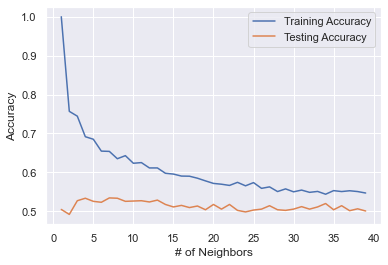

{'k = 1': 50.48, 'k = 2': 49.2, 'k = 3': 52.72, 'k = 4': 53.36, 'k = 5': 52.56, 'k = 6': 52.32, 'k = 7': 53.44, 'k = 8': 53.36, 'k = 9': 52.56, 'k = 10': 52.64, 'k = 11': 52.72, 'k = 12': 52.4, 'k = 13': 52.88, 'k = 14': 51.76, 'k = 15': 51.12, 'k = 16': 51.52, 'k = 17': 50.96, 'k = 18': 51.36, 'k = 19': 50.4, 'k = 20': 51.76, 'k = 21': 50.56, 'k = 22': 51.76, 'k = 23': 50.24, 'k = 24': 49.84, 'k = 25': 50.32, 'k = 26': 50.56, 'k = 27': 51.44, 'k = 28': 50.4, 'k = 29': 50.24, 'k = 30': 50.56, 'k = 31': 51.2, 'k = 32': 50.56, 'k = 33': 51.12, 'k = 34': 52.0, 'k = 35': 50.4, 'k = 36': 51.44, 'k = 37': 50.16, 'k = 38': 50.64, 'k = 39': 50.08}
최대 예측 일치 비율: k = 7: 53.44
최소 예측 일치 비율: k = 2: 49.2

Most Accurate k: 7

테스트 데이터 개수: 1250
예측과 일치한 데이터 개수: 668
일치 비율: 53.44 %
Accuracy : 0.534
Precision : 0.506
Recall : 0.482
F1 : 0.494


In [7]:
'''best_k 찾기'''

def process_knn_k (df, X_factors, Y_factors):

    '''Train, Test분류 (시계열 데이터 이므로 섞지 않는 것이 중요)'''
    X = df[X_factors]
    Y = df[Y_factors[0]]

    '''테스트 데이터 나누기'''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, shuffle=False) #섞지않고

    '''전일 대비 금일의 변화율로 모든 변수의 스케일이 동일 > 정규화 진행 X'''
    #preprocessor = preprocessing.Normalizer()
    #X_train = preprocessor.fit_transform(X_train)
    #X_test = preprocessor.transform(X_test)

    training_accuracy = []
    test_accuracy = []
    dict = {}
    n_test = len(Y_test)
    k_settings = range(1,40)
    for i in k_settings:
        ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=i)
        ploan_knn.fit(X_train, Y_train)
        training_accuracy.append(ploan_knn.score(X_train, Y_train))
        test_accuracy.append(ploan_knn.score(X_test, Y_test))
        Y_predict = ploan_knn.predict(X_test)

        a = round((sum(Y_test == Y_predict)/n_test)*100, 2)
        dict[f'k = {i}'] = a

    plt.plot(k_settings, training_accuracy, label="Training Accuracy")
    plt.plot(k_settings, test_accuracy, label="Testing Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("# of Neighbors")
    plt.legend()
    plt.show()

    print(dict)
    max_dict = max(dict, key=lambda x: dict[x])
    min_dict = min(dict, key=lambda x: dict[x])
    best_k_temp = test_accuracy==max(test_accuracy)
    best_k = list(compress(k_settings, best_k_temp))[0]
    print(f'최대 예측 일치 비율: {max_dict}: {dict.get(max_dict)}')
    print(f'최소 예측 일치 비율: {min_dict}: {dict.get(min_dict)}')
    print('\nMost Accurate k:', best_k)

    '''best k 에서의 모델 성능 평가'''

    best_ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
    best_ploan_knn.fit(X_train, Y_train)
    best_ploan_knn.predict(X_test)

    n_test = len(Y_test)
    Y_predict = best_ploan_knn.predict(X_test)

    print('\n테스트 데이터 개수:', n_test)
    print('예측과 일치한 데이터 개수:', sum(Y_test == Y_predict))
    print('일치 비율:',round((sum(Y_test == Y_predict)/n_test)*100,2),'%')

    accuracy = accuracy_score(Y_test, Y_predict)
    precision = precision_score(Y_test, Y_predict)
    recall = recall_score(Y_test, Y_predict)
    f1 = f1_score(Y_test, Y_predict)
    print('Accuracy : {0:.3f}'.format(accuracy))
    print('Precision : {0:.3f}'.format(precision))
    print('Recall : {0:.3f}'.format(recall))
    print('F1 : {0:.3f}'.format(f1))

    return best_k

best_k = process_knn_k(df, X_factors, Y_factors)

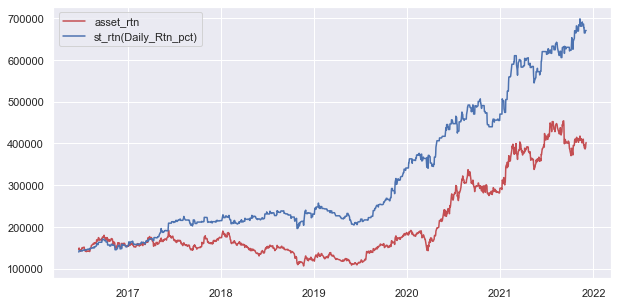

naver's Buy and Hold strategy  return: 175.34%
naver's KNN strategy trading return: 379.43%
naver's Sharpe Ratio: 0.6821210619625723


In [8]:
'''best k와 KNN을 활용한 투자 전략 수익률 테스트'''

def trading_strategy_rtn (best_k, df, X_factors, Y_factors):

    X = df[X_factors]
    Y = df[Y_factors[0]]

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, test_size=0.3, shuffle=False) #섞지않고

    best_ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
    best_ploan_knn.fit(X_train, Y_train)
    split = int(0.7*len(df))

    '''KNN예측 등락 시그널'''

    df['st_signal'] = best_ploan_knn.predict(X)

    '''초기 투자금'''

    initial_fund = df[split:]['asset_Open'][0]
    #현실의 경우, 투자금이 100만원일 경우 몇주를 사게되는지 따져봐야하지만, 일단은 open가격에 사는것으로 가정

    '''시장 수익률 데이터(시장 종가)'''

    df['mkt_rtn'] = df[split:]['asset_Close']# - df[split:]['asset_Open'][0]
    cum_mkt_rtn = df[split:]['mkt_rtn']

    '''KNN전략 수익률 데이터(일일 매수매도)'''

    df['st_signal'] = df['st_signal'].shift(1) #계산에 활용하기 위해 한칸 미뤄줌
    df['rtn_pct'] = df['asset_Close'].pct_change()
    #슬리피지의 존재 여부가 수익률에 영향을 주고 있음
    #전날 종가의 가격으로 구매가 가능하다면 큰 수익률을 얻을 수 있으나, 현재의 시가로 구매하게 된다면 수익률이 크게 낮아짐
    #이는 슬리피지로 인한 효과를 생각해야 함을 시사함.

    for i in df[split:].index:
        if df.loc[i, 'st_signal'] == 0:
            df.loc[i, 'st_rtn'] = initial_fund#오르지 않음을 예측시 매수매도가 이뤄지지 않으니 초기투자금 그대로
        else:
            df.loc[i, 'st_rtn'] = ( df.loc[i, 'rtn_pct'] + 1 ) * initial_fund
            initial_fund = df.loc[i, 'st_rtn'] #오른다고 예측시 매수매도 이후, 당일 상승분을 가져감


    df['st_real_rtn'] = df[split:]['st_rtn']# - df[split:]['asset_Open'][0]

    cum_st_rtn = df[split:]['st_real_rtn']

    try:
        os.mkdir(path_dir + "/" + "Data_pic")
    except:
        pass

    plt.figure(figsize=(10,5))
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    plt.plot(cum_mkt_rtn, color='r', label='asset_rtn')
    plt.plot(cum_st_rtn, color='b', label='st_rtn(Daily_Rtn_pct)')
    plt.legend()
    plt.savefig(f'{path_dir}/Data_pic/Return Compare on KNN modeling_{asset_name}.png')
    plt.show()

    net_mkt_rtn = ((cum_mkt_rtn[len(cum_mkt_rtn)-1] - cum_mkt_rtn[0]) / cum_mkt_rtn[0]) * 100
    net_st_rtn = ((cum_st_rtn[len(cum_st_rtn)-1] - cum_st_rtn[0]) / cum_st_rtn[0]) * 100
    print(f"{asset_name}'s Buy and Hold strategy  return: {round(net_mkt_rtn,2)}%")
    print(f"{asset_name}'s KNN strategy trading return: {round(net_st_rtn,2)}%")

    #샤프비율로 비교 ( (자산의 기대수익률 - 기준지표의 기대수익률) / 자산 수익률의 표준편차 : 기준지표 대비 초과수익비율)

    std = cum_st_rtn.std()
    sharpe = (cum_st_rtn - cum_mkt_rtn)/std
    sharpe = sharpe.mean()
    print(f"{asset_name}'s Sharpe Ratio: {sharpe}")

trading_strategy_rtn(best_k, df, X_factors, Y_factors)

In [9]:

'''코스피 전체 데이터 분석 및 승률 조회'''
# 
# '''승률데이터 저장'''
# data_dict = {}
# data_dict2 = {}
# 
# '''데이터가 충분히 길지 않아서 저장 안될 경우'''
# error_list = []
# 
# '''반복용'''
# path_dir = os.getcwd()
# file_list = os.listdir(f'{path_dir}/Data')
# 
# tmp2 = pd.read_csv(f"{path_dir}/Data_mkt/kospi.csv", index_col='Date', parse_dates=['Date']) #코스피지수
# tmp3 = pd.read_csv(f'{path_dir}/Data_mkt/nasdaq.csv', index_col='Date', parse_dates=['Date']) #나스닥 지수
# tmp4 = pd.read_csv(f'{path_dir}/Data_mkt/s&p500.csv', index_col='Date', parse_dates=['Date']) #S&P500 지수
# tmp5 = pd.read_csv(f'{path_dir}/Data_mkt/dowjones.csv', index_col='Date', parse_dates=['Date']) #DowJones 지수
# tmp6 = pd.read_csv(f'{path_dir}/Data_mkt/exch.csv', index_col='Date', parse_dates=['Date']) #원달러 환율 지수
#
# for i in file_list:
#     try:
#         asset_name = i
#         tmp1 = pd.read_csv(f"{path_dir}/Data/{i}", index_col='Date', parse_dates=['Date'])
#         data = [tmp1, tmp2, tmp3, tmp4, tmp5, tmp6]

#         tmp = process_time(data)
#         df, X_factors, Y_factors = process_factors(tmp)

#         X = df[X_factors]
#         Y = df[Y_factors[0]]
#         train_ratio = 0.7
#         X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=train_ratio, test_size=(1-train_ratio), shuffle=False) #섞지않고

#         training_accuracy = []
#         test_accuracy = []
#         k_settings = range(1, 40)

#         for k in k_settings:
#             ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=k)
#             ploan_knn.fit(X_train, Y_train)
#             training_accuracy.append(ploan_knn.score(X_train, Y_train))
#             test_accuracy.append(ploan_knn.score(X_test, Y_test))

#         best_k_temp = test_accuracy==max(test_accuracy)
#         best_k = list(compress(k_settings, best_k_temp))[0]

#         best_ploan_knn = neighbors.KNeighborsClassifier(n_neighbors=best_k)
#         best_ploan_knn.fit(X_train, Y_train)
#         split = int(train_ratio*len(df))

#         '''KNN예측 등락 시그널'''

#         df['st_signal'] = best_ploan_knn.predict(X)

#         '''초기 투자금'''

#         initial_fund = df[split:]['asset_Open'][0]
#         #현실의 경우, 투자금이 100만원일 경우 몇주를 사게되는지 따져봐야하지만, 일단은 open가격에 사는것으로 가정

#         '''시장 수익률 데이터(시장 종가)'''

#         df['mkt_rtn'] = df[split:]['asset_Close']# - df[split:]['asset_Open'][0]
#         cum_mkt_rtn = df[split:]['mkt_rtn']

#         '''KNN전략 수익률 데이터(일일 매수매도)'''

#         df['st_signal'] = df['st_signal'].shift(1) #계산에 활용하기 위해 한칸 미뤄줌
#         df['rtn_pct2'] = (df['asset_Close'] - df['asset_Open']) / df['asset_Open']
#         df['rtn_pct'] = df['asset_Close'].pct_change()
#         #슬리피지의 존재 여부가 수익률에 큰 영향을 주고 있음
#         #전날 종가의 가격으로 구매가 가능하다면 큰 수익률을 얻을 수 있으나, 현재의 시가로 구매하게 된다면 수익률이 크게 낮아짐
#         #이는 슬리피지로 인한 효과를 생각해야 함을 시사함.
#         initial_fund2 = df[split:]['asset_Open'][0]

#         for i in df[split:].index:
#             if df.loc[i, 'st_signal'] == 0:
#                 df.loc[i, 'st_rtn'] = initial_fund #오르지 않음을 예측시 매수매도가 이뤄지지 않으니 초기투자금 그대로
#                 df.loc[i, 'st_rtn2'] = initial_fund2
#             else:
#                 df.loc[i, 'st_rtn'] = ( df.loc[i, 'rtn_pct'] + 1 ) * initial_fund
#                 df.loc[i, 'st_rtn2'] = ( df.loc[i, 'rtn_pct'] + 1 ) * initial_fund2
#                 initial_fund = df.loc[i, 'st_rtn'] #오른다고 예측시 매수매도 이후, 당일 상승분을 가져감
#                 initial_fund2 = df.loc[i, 'st_rtn2']

#         df['st_real_rtn'] = df[split:]['st_rtn']# - df[split:]['asset_Open'][0]
#         cum_st_rtn = df[split:]['st_real_rtn']
#         cum_st_rtn2 = df[split:]['st_rtn2']

#         '''사진저장 옵션'''

#         try:
#             os.mkdir(path_dir + "/" + "Data_pic")
#         except:
#             pass

#         #plt.figure(figsize=(10,5))
#         #plt.plot(cum_mkt_rtn, color='r', label='asset_ret')
#         #plt.plot(cum_st_rtn, color='g', label='st_ret')
#         #plt.legend()
#         #plt.savefig(f'{path_dir}/Data_pic/Return Compare on KNN modeling_{asset_name}.png')
#         #plt.show()

#         #net_mkt_rtn = ((cum_mkt_rtn[len(cum_mkt_rtn)-1] - cum_mkt_rtn[0]) / cum_mkt_rtn[0]) * 100
#         #net_st_rtn = ((cum_st_rtn[len(cum_st_rtn)-1] - cum_st_rtn[0]) / cum_st_rtn[0]) * 100
#         data_dict[f'{asset_name}'] = cum_st_rtn[len(cum_st_rtn)-1] - cum_mkt_rtn[len(cum_mkt_rtn)-1]
#         data_dict[f'{asset_name}'] = cum_st_rtn2[len(cum_st_rtn2)-1] - cum_mkt_rtn[len(cum_mkt_rtn)-1]
#         #print(f"{asset_name}'s Buy and Hold strategy return: {round(net_mkt_rtn,2)}%")
#         #print(f"{asset_name}'s KNN strategy return: {round(net_st_rtn,2)}%")

#         #샤프비율로 비교 ( (자산의 기대수익률 - 기준지표의 기대수익률) / 자산 수익률의 표준편차 : 기준지표 대비 초과수익비율)

#         #std = cum_st_rtn.std()
#         #sharpe = (cum_st_rtn - cum_mkt_rtn)/std
#         #sharpe = sharpe.mean()
#         #print(f"{asset_name}'s Share Ratio: {sharpe}")

#     except:
#         error_list.append(asset_name)
#         pass

# print(data_dict)
# print(data_dict2)

# def winning_rate (dic):
#     a = 0
#     b = 0
#     c = 0
#     for i in dic.values():
#         if i > 0:
#             a += 1
#         elif i == 0:
#             b += 1
#         else:
#             c += 1

#     print(f'이김:{a}, 비김:{b}, 짐:{c}')
#     print(f'승률: {a/(a+b+c)}')
#     return

# winning_rate(data_dict)
# winning_rate(data_dict2)


'코스피 전체 데이터 분석 및 승률 조회'